In [1]:
## Preliminaries

using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

using AdvancedHMC
using ArviZ
using BumpCosmologyGWTC3
using CairoMakie
using Colors
using Cosmology
using DataFrames
using DimensionalData
using Distributions
using GaussianKDEs
using HDF5
using InferenceObjects
#using Interpolations
using JSON
using LaTeXStrings
using MCMCChainsStorage
using NCDatasets
using PairPlots
using PolyLog
using PopModels
using Printf
using ProgressLogging
using Random
using StatsBase
using SpecialFunctions
using StatsFuns
using Trapz
using Turing
using Unitful
using UnitfulAstro
using UnitfulChainRules

include("plots.jl")

  Activating project at `~/35_GWTC4_mid/Oct12_beta_q`


h_plot (generic function with 1 method)

# Load GWTC-3 Parameter Estimation and Selection Samples

In [2]:
## Set up paths

## Output Directory for Plots and Astro Comparison Plot
outdir = "/mnt/home/sroy1/35Msun_GWTC3/paper_plots/plots/"
savepath = "../data/Astro_Compare_Feature_m1m2.h5" #first run m1_marginal to write h5py file, for rest, it will append

## Plot Specifications
xlabelsize = 30
ylabelsize = 30
xticklabelsize = 23
yticklabelsize = 23
titlesize = 35
draws = 500

plot_save = false

false

# Population Plots

In [3]:
trace_samples_0p5 = from_netcdf(joinpath(@__DIR__, "..", "data", "chains_0.5.nc"))
ne_min = dropdims(minimum(trace_samples_0p5.posterior.Neff_samps, dims=(:chain, :draw)); dims=(:chain, :draw))
ns_min = minimum(trace_samples_0p5.posterior.Neff_sel)
@info "p_cut = 0.5, minimum Neff_samps: $(round(minimum(ne_min), digits=2)), minimum Neff_sel = $(round(ns_min, digits=1)), 4*Nobs = $(4*length(dims(trace_samples_0p5.posterior, :event)))"
trace = trace_samples_0p5

┌ Info: p_cut = 0.5, minimum Neff_samps: 4.04, minimum Neff_sel = 941.6, 4*Nobs = 460
└ @ Main /mnt/home/sroy1/35_GWTC4_mid/Oct12_beta_q/scripts/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sdnNjb2RlLXJlbW90ZQ==.jl:4


InferenceData with groups:
  > posterior
  > sample_stats

### Load GWTC3 Power Law + Peak Fit
Loaded from /mnt/home/sroy1/GWTC3/Rates/GWTC3_PLPP.h5

In [21]:
function load_GWTC3_population_data(filepath::String)
    h5open(filepath, "r") do file
        m1_GWTC3 = read(file["ms"])
        q_GWTC3 = read(file["qs"])
        z_GWTC3 = read(file["zs"])
        Rm1_med = read(file["Rm_med"])
        Rm1_5 = read(file["Rm_5"])
        Rm1_95 = read(file["Rm_95"])
        Rq_med = read(file["Rq_med"])
        Rq_5 = read(file["Rq_5"])
        Rq_95 = read(file["Rq_95"])
        Rz_med = read(file["Rz_med"])
        Rz_5 = read(file["Rz_5"])
        Rz_95 = read(file["Rz_95"])

        chieff_GWTC3 = read(file["chieffs"])
        Rchieff_med = read(file["Rchieff_med"])
        Rchieff_5 = read(file["Rchieff_5"])
        Rchieff_95 = read(file["Rchieff_95"])
        Rchieff_cdf_med = read(file["Rchieff_cdf_med"])
        Rchieff_cdf_5 = read(file["Rchieff_cdf_5"])
        Rchieff_cdf_95 = read(file["Rchieff_cdf_95"])


        return (; m1_GWTC3, q_GWTC3, z_GWTC3, Rm1_med, Rm1_5, Rm1_95, Rq_med, Rq_5, Rq_95, Rz_med, Rz_5, Rz_95, chieff_GWTC3, Rchieff_med, Rchieff_5, Rchieff_95, Rchieff_cdf_med, Rchieff_cdf_5, Rchieff_cdf_95)
    end
end

m1_GWTC3, q_GWTC3, z_GWTC3, Rm1_med, Rm1_5, Rm1_95, Rq_med, Rq_5, Rq_95, Rz_med, Rz_5, Rz_95, chieff_GWTC3, Rchieff_med, Rchieff_5, Rchieff_95, Rchieff_cdf_med, Rchieff_cdf_5, Rchieff_cdf_95 = load_GWTC3_population_data("/mnt/home/sroy1/35Msun_GWTC3/compare_data/GWTC3_PLPP.h5")

(m1_GWTC3 = [2.0, 2.098098098098098, 2.196196196196196, 2.294294294294294, 2.3923923923923924, 2.4904904904904903, 2.5885885885885886, 2.6866866866866865, 2.784784784784785, 2.8828828828828827  …  99.11711711711712, 99.21521521521521, 99.31331331331332, 99.41141141141141, 99.5095095095095, 99.6076076076076, 99.7057057057057, 99.8038038038038, 99.9019019019019, 100.0], q_GWTC3 = [0.1, 0.10180360721442887, 0.10360721442885772, 0.10541082164328658, 0.10721442885771544, 0.10901803607214429, 0.11082164328657315, 0.11262525050100201, 0.11442885771543086, 0.11623246492985972  …  0.9837675350701403, 0.9855711422845691, 0.987374749498998, 0.9891783567134268, 0.9909819639278556, 0.9927855711422846, 0.9945891783567135, 0.9963927855711423, 0.9981963927855712, 1.0], z_GWTC3 = [0.0, 0.015151515151515152, 0.030303030303030304, 0.045454545454545456, 0.06060606060606061, 0.07575757575757576, 0.09090909090909091, 0.10606060606060606, 0.12121212121212122, 0.13636363636363635  …  1.3636363636363638, 1.378

## $m_1$ Marginal

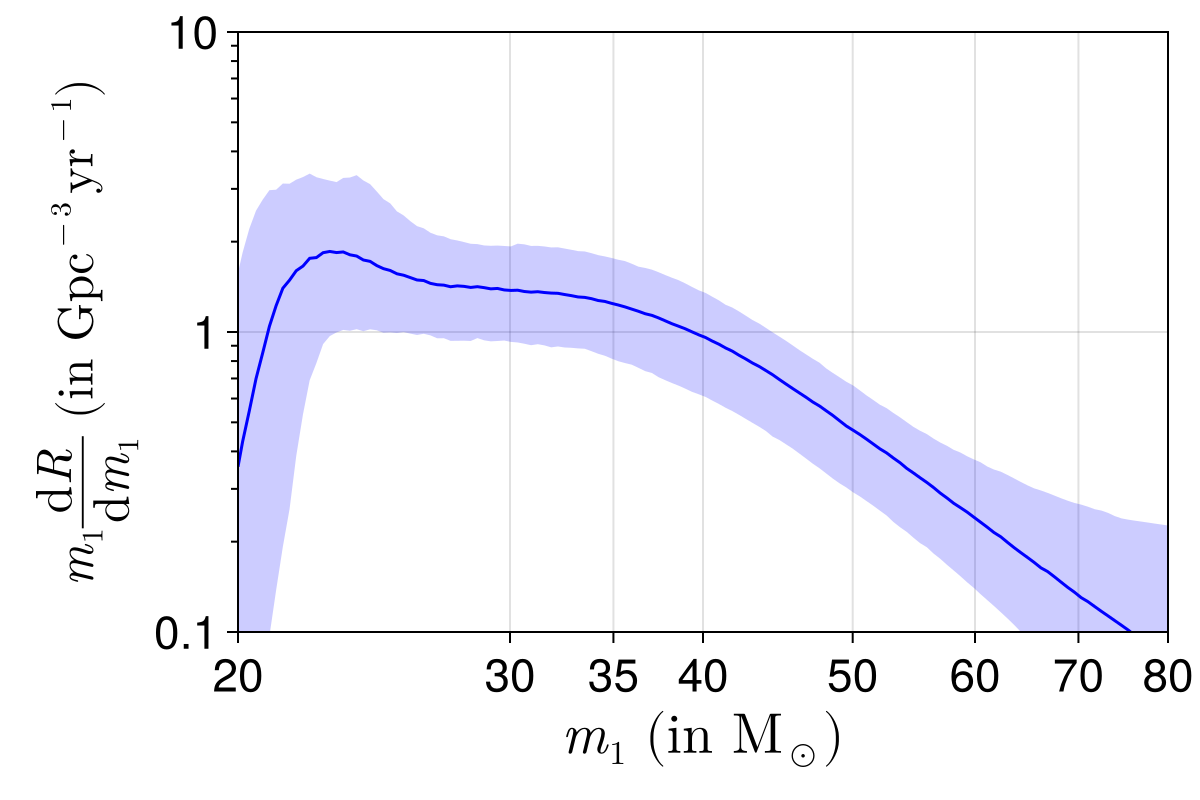

In [5]:
z_plot = 0.0
function marginal_m1_plot_paper(trace; limits=(20.0, 80.0, 0.1, 10.0), yticks=[0.01, 0.1, 1, 10, 100], yminorticks=[0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,2,3,4,5,6,7,8,9,20], kwargs...)
    f = Figure(size=(600, 400))
    a = Axis(f[1,1],
    xlabel = L"m_1~(\mathrm{in~}\mathrm{M}_\odot)",
    ylabel = L"m_1 \frac{\mathrm{d} R}{\mathrm{d} m_1}~(\mathrm{in~}\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1})",
    xscale = log10, yscale = log10,
    xticks = [20, 30, 35, 40, 50, 60, 70, 80], xtickformat = "{:.0f}",
    yticks = ([0.01, 0.1, 1.0, 10.0, 100.0], ["0.01", "0.1", "1", "10", "100"]),
    yminorticks = yminorticks, yminorticksvisible = true,
    xlabelsize = 28,
    ylabelsize = 25,
    xticklabelsize = xticklabelsize,
    yticklabelsize = yticklabelsize,
    limits = limits)

    marginal_m1_plot_paper!(a, trace; kwargs...)

    # axislegend(a, position = :lb, labelsize = 21, framevisible = true)  # top-right inside the plot

    f
end


function marginal_m1_plot_paper!(a, trace; z_plot=z_plot, ms=exp.(log(m_bh_min):0.01:log(m_bh_max)), qs=0.001:0.01:1, draws=1000, rng=Random.default_rng(), color=Makie.wong_colors()[1], label="Median", savepath=savepath)
    p = trace.posterior
    dNdm1_matrix = zeros(length(ms), draws)

    @progress for i in 1:draws
        d = rand(rng, span(dims(p, :draw)))
        c = rand(rng, 1:length(dims(p, :chain)))
        log_dN = log_dN_from_chain_sample(trace, d, c)

        dNdm1 = map(ms) do m
            integrand = map(qs) do q
                m2 = q * m
                if m2 < m_bh_min
                    zero(m)
                else
                    exp(log_dN(m, q, z_plot))
                end
            end
            m * p.R[chain=c, draw=d] * trapz(qs, integrand)
        end

        dNdm1_matrix[:, i] = dNdm1
    end

    q5 = mapslices(x -> quantile(x, 0.05), dNdm1_matrix; dims=2)[:]
    q50 = mapslices(x -> quantile(x, 0.50), dNdm1_matrix; dims=2)[:]
    q95 = mapslices(x -> quantile(x, 0.95), dNdm1_matrix; dims=2)[:]

    band!(a, ms, q5, q95, color=(:blue, 0.2), label=L"\mathrm{This~Work}: 35\,\mathrm{M}_{\odot} \mathrm{Pop}")
    lines!(a, ms, q50, color=:blue)
    
end

f = marginal_m1_plot_paper(trace)
f

## Marginal $q$

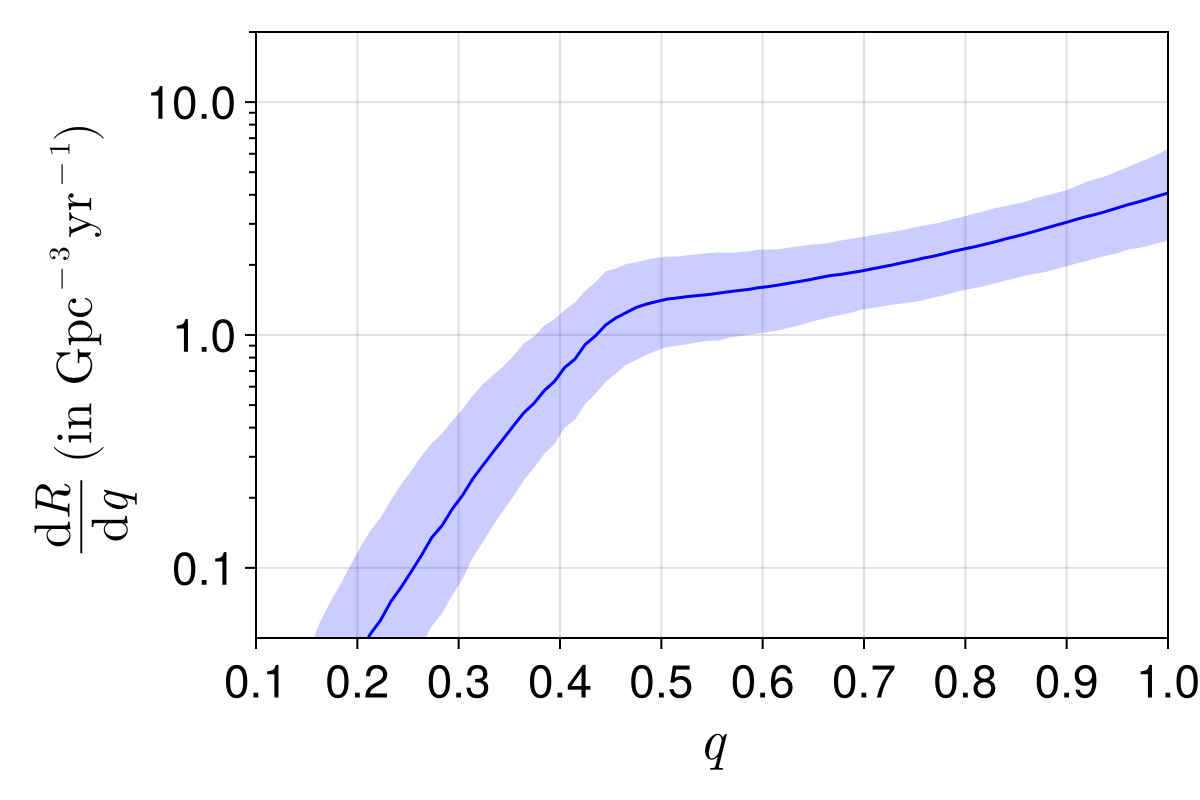

In [6]:
z_plot = 0.0
function marginal_q_plot_paper(trace; z_plot=z_plot, ms=exp.(log(m_bh_min):0.01:log(m_bh_max)), qs=collect(range(0.001, stop=1.0, length=100)), draws=draws, rng=Random.default_rng(), limits=(0.1, 1, 0.05, 20), yticks=[0.1, 1, 10, 100, 1000, 10000], yminorticks=[0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,2,3,4,5,6,7,8,9,20,30,40,50,60,70,80,90,200,300,400,500,600,700,800,900,2000,3000,4000,5000,6000,7000,8000,9000], color=Makie.wong_colors()[1], savepath=savepath)
    
    f = Figure(size=(600, 400))
    
    a = Axis(f[1,1],
        xlabel = L"q",
        ylabel = L"\frac{\mathrm{d} R}{\mathrm{d} q}~(\mathrm{in~}\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1})",
        yscale = log10,
        yticks = yticks,
        yminorticks = yminorticks,
        yminorticksvisible = true,
        ytickformat = "{:.1f}",
        xlabelsize = 28,
        ylabelsize = 25,
        xticklabelsize = xticklabelsize,
        yticklabelsize = yticklabelsize,
        limits = limits
    )

    p = trace.posterior
    dNdq_matrix = zeros(length(qs), draws)

    @progress for i in 1:draws
        d = rand(rng, span(dims(p, :draw)))
        c = rand(rng, span(dims(p, :chain)))
        log_dN = log_dN_from_chain_sample(trace, d, c)

        dNdq = map(qs) do q
            integrand = map(ms) do m
                m2 = q * m
                if m2 < m_bh_min
                    zero(m)
                else
                    exp(log_dN(m, q, z_plot))
                end
            end
            p.R[chain=c, draw=d] * trapz(ms, integrand)
        end

        dNdq_matrix[:, i] = dNdq
    end

    # Compute quantiles
    q5 = mapslices(x -> quantile(x, 0.05), dNdq_matrix; dims=2)[:]
    q50 = mapslices(x -> quantile(x, 0.50), dNdq_matrix; dims=2)[:]
    q95 = mapslices(x -> quantile(x, 0.95), dNdq_matrix; dims=2)[:]

    band!(a, qs, q5, q95, color=(:blue, 0.2), label=L"\mathrm{This~Work}: 35\,\mathrm{M}_{\odot} \mathrm{Pop}")
    lines!(a, qs, q50, color=:blue)
    
    return f

end

f = marginal_q_plot_paper(trace)
f


## Marginal $z$

imin = 37


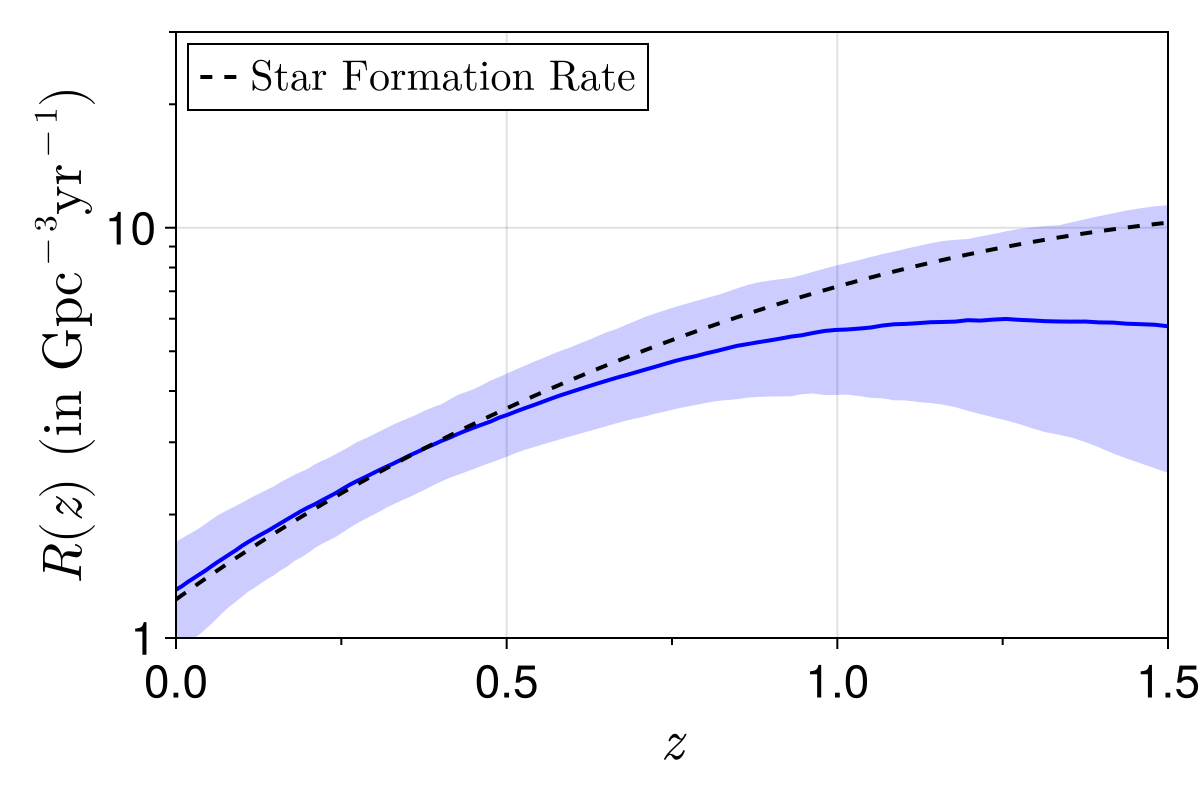

In [7]:
function marginal_z_plot_paper(trace;
    ms = exp.(log(m_bh_min):0.01:log(m_bh_max)),
    qs = 0.001:0.01:1,
    zs = expm1.(range(log(1), stop=log(1 + 2), length=128)),
    draws = draws,
    rng = Random.default_rng(),
    limits = (0, 1.5, 1, 30),
    yticks = [1, 10, 100, 1000],
    yminorticks = [2,3,4,5,6,7,8,9,20,30,40,50,60,70,80,90,200,300,400,500,600,700,800,900],
    plot_md_line = true,
    color = Makie.wong_colors()[1],
    savepath = savepath
)
    f = Figure(size=(600, 400))
    a = Axis(f[1, 1],
        xlabel = L"z",
        ylabel = L"R(z)~(\mathrm{in~}\mathrm{Gpc}^{-3}\mathrm{yr}^{-1})",
        yscale = log10,
        xlabelsize = 28,
        ylabelsize = 28,
        xticklabelsize = xticklabelsize,
        yticklabelsize = yticklabelsize,
        ytickformat = "{:.0f}",
        yticks = yticks,
        yminorticks = yminorticks,
        yminorticksvisible = true,
        xminorticksvisible = true,
        limits = limits
    )

    p = trace.posterior
    dNs = zeros(length(zs), draws)

    @progress for j in 1:draws
        c = rand(rng, span(dims(p, :chain)))
        d = rand(rng, span(dims(p, :draw)))
        log_dN = log_dN_from_chain_sample(trace, d, c)

        z1 = zs[1]
        dNdms = map(ms) do m
            integrand = map(qs) do q
                m2 = q * m
                if m2 < m_bh_min
                    zero(m)
                else
                    exp(log_dN(m, q, z1))
                end
            end
            trapz(qs, integrand)
        end

        norm = trace.posterior.R[draw=d, chain=c] *
               trapz(ms, dNdms) /
               exp(log_dN(m_plot, q_plot, z1))

        dNdz = map(zs) do z
            norm * exp(log_dN(m_plot, q_plot, z))
        end

        dNs[:, j] = dNdz
    end

    #imin = argmin(Rz_95 - Rz_5)
    vs = vec(var(log.(dNs), dims=2))
    imin = argmin(vs)
    @show imin
    
    medians = mapslices(median, dNs; dims=2)[:]
    lowers = mapslices(x -> quantile(x, 0.05), dNs; dims=2)[:]
    uppers = mapslices(x -> quantile(x, 0.95), dNs; dims=2)[:]
    norm = medians[imin]


    band_plot = band!(a, zs, lowers, uppers, color=(:blue, 0.2))
    median_plot = lines!(a, zs, medians, color=:blue, linewidth=2)

    sfr_plot = nothing
    if plot_md_line
        mds = @. (1 + zs)^2.7 / (1 + ((1 + zs)/(1 + 1.9))^5.6)
        mds = mds .* norm ./ mds[imin]

        sfr_plot = lines!(a, zs, mds, color=:black, linestyle=:dash, linewidth=2, label=L"\mathrm{Star~Formation~Rate}")
    end

    axislegend(a, position = :lt, labelsize = 21, framevisible = true)
    
    return f
end

f = marginal_z_plot_paper(trace)
f

## Print Median, 5% and 95% Values

In [8]:
function summarize_trace(trace)
    println("Parameter\tMedian\t5%\t95%")
    for (name, values) in pairs(trace.posterior)
        flat_values = vec(Array(values))  # Flatten all chains and draws into a 1D array
        median_val = median(flat_values)
        lower_val = quantile(flat_values, 0.05)
        upper_val = quantile(flat_values, 0.95)
        println("$(name)\t$(round(median_val, sigdigits=5))\t$(round(median_val-lower_val, sigdigits=5))\t$(round(upper_val-median_val, sigdigits=5))")
    end
end

summarize_trace (generic function with 1 method)

In [9]:
summarize_trace(trace)

Parameter	Median	5%	95%
mbreakf1	21.682	1.4247	2.2485
sigma_peak2	5.3042	3.1901	3.3505
alphahm2	3.5615	3.1148	2.2343
m1_draw	36.831	13.976	29.468
alphalm2	2.8194	5.1558	5.2181
Neff_samps	30.568	18.528	72.032
log_rlm2	-3.178	1.2224	1.6478
alphahm1	2.8274	4.7534	5.3153
lambda	2.5509	0.49367	1.0137
m2s	29.668	17.171	12.006
qs	0.80113	0.38174	0.1756
kappa	6.1589	2.7084	1.6711
alphalm1	-27.039	20.724	24.051
rlm2	0.041667	0.029396	0.17482
mbreaks1	35.076	4.6935	4.483
R	12.313	11.533	1036.9
m1s	36.375	13.74	31.89
rhm2	0.068876	0.0565	0.32804
alphamm1	4.3723	5.044	4.765
Neff_sel	2143.2	634.86	503.21
q_draw	0.81114	0.42492	0.17144
log_rhm2	-2.6754	1.7165	1.7514
beta	2.4398	5.0771	4.69
zs	0.45213	0.30674	0.56173
m2_draw	29.732	15.606	12.663
z_draw	0.46543	0.3319	0.69767
zp	1.2501	0.23421	1.9319
mu_peak2	31.611	4.908	7.1539


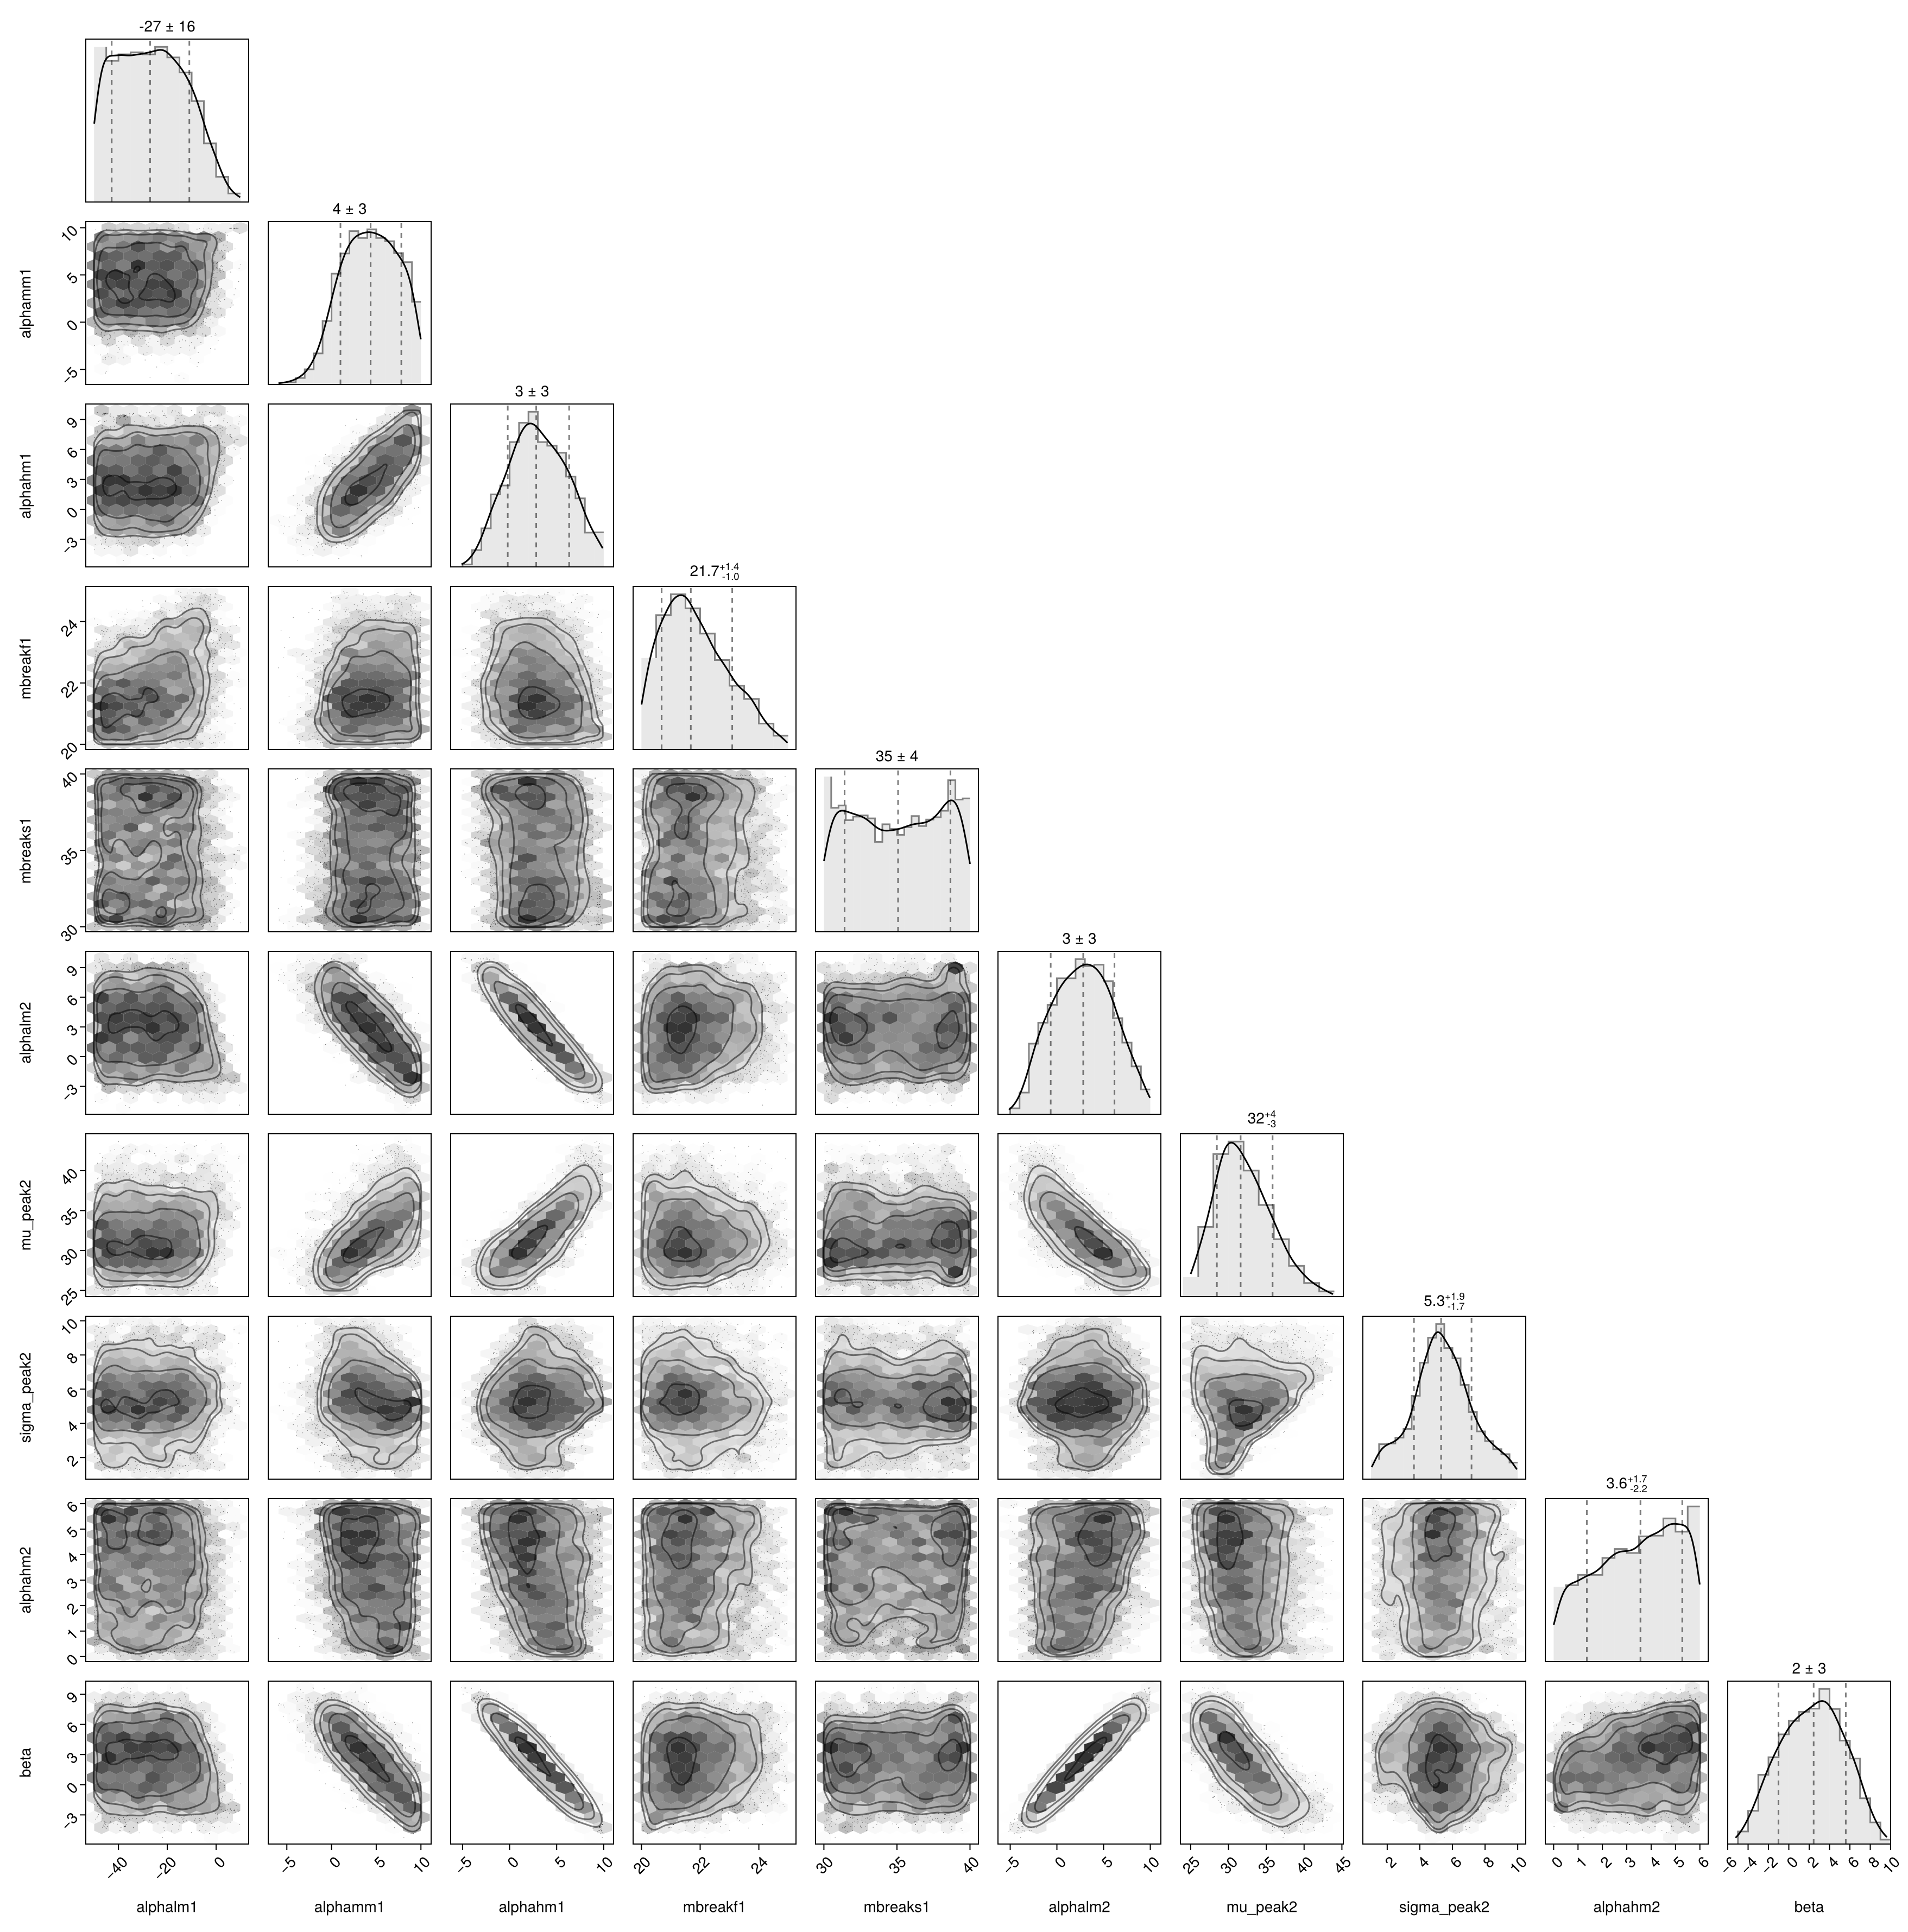

CairoMakie.Screen{IMAGE}


In [4]:
using DataFrames
using PairPlots
using CairoMakie

alphalm1_samples = vec(trace[:posterior][:alphalm1])
alphamm1_samples = vec(trace[:posterior][:alphamm1])
alphahm1_samples = vec(trace[:posterior][:alphahm1])
mbreakf1_samples = vec(trace[:posterior][:mbreakf1])
mbreaks1_samples = vec(trace[:posterior][:mbreaks1])
alphalm2_samples = vec(trace[:posterior][:alphalm2])
mu_peak2_samples = vec(trace[:posterior][:mu_peak2])
sigma_peak2_samples = vec(trace[:posterior][:sigma_peak2])
alphahm2_samples = vec(trace[:posterior][:alphahm2])
beta_samples = vec(trace[:posterior][:beta])

df = DataFrame(
    alphalm1 = alphalm1_samples,
    alphamm1 = alphamm1_samples,
    alphahm1 = alphahm1_samples,
    mbreakf1 = mbreakf1_samples,
    mbreaks1 = mbreaks1_samples,
    alphalm2 = alphalm2_samples,
    mu_peak2 = mu_peak2_samples,
    sigma_peak2 = sigma_peak2_samples,
    alphahm2 = alphahm2_samples,
    beta = beta_samples
)

fig = PairPlots.pairplot(df)

display(fig)